# Imports

In [17]:
import sys
import time

import numpy as np
import torch
from bnpm import file_helpers, optimization
import sklearn.utils.class_weight
from torch import nn, optim
from tqdm import tqdm
import sklearn.linear_model
import multiprocessing as mp

import roicat.classification.classifier_util as cu
import scipy.sparse
import roicat
import bnpm.h5_handling
from pathlib import Path
import shutil
import warnings
import umap

import matplotlib.pyplot as plt
import matplotlib.offsetbox
import json
import os
import natsort
from roicat import helpers
# from kymatio.torch import Scattering2D
import gc
import functools

# Specify Initial Parameters

In [2]:
path_params = None # Path(r"")
directory_data = r'/Users/josh/analysis/outputs/ROICaT/classification/00_data_ingestion'
directory_save = r'/Users/josh/analysis/outputs/ROICaT/classification/01_labels'
testing = True
save_ROIs = True
save_latents = True

In [3]:
directory_save = Path(directory_save)
directory_save.mkdir(exist_ok=True, parents=True)

labelingRun_interim = {}

if path_params is not None:
    try:
        Path(str((directory_save).resolve())).mkdir(exist_ok=True, parents=True)
        shutil.copy2(path_params, str(Path(directory_save) / Path(path_params).name));
    except Exception as e:
        print(f'JZ: Error copying params to {directory_save}')
        print(e)
tic = time.time()
tictoc = {}
tictoc['start'] = time.time() - tic

params = file_helpers.json_load(str(Path(path_params).resolve())) if path_params is not None else None

In [4]:
# %matplotlib notebook
# dir_allOuterFolders = str(Path('/Users/josh/analysis/data/ROICaT/classification/raw_images').resolve())
dir_allOuterFolders = str(Path('/Users/josh/analysis/data/ROICaT/classification/stat_s2p').resolve())

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'

paths_allStat = test = helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToStat,
    depth=4,
)
paths_allOps = test = helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToOps,
    depth=4,
)

display(paths_allStat)
display(paths_allOps)

#Import data
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',
    out_height_width=[36, 36],
    type_meanImg='meanImgE',
    verbose=True,
);

['/Users/josh/analysis/data/ROICaT/classification/stat_s2p/stat.npy']

['/Users/josh/analysis/data/ROICaT/classification/stat_s2p/ops.npy']

/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:191: UserWarning: RH WARNING: unable to get cpu info. Got error: No module named 'cpuinfo'
  warnings.warn(f'RH WARNING: unable to get cpu info. Got error: {e}')
/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:210: UserWarning: RH WARNING: unable to get gpu info. Got error: No module named 'GPUtil'
  warnings.warn(f'RH WARNING: unable to get gpu info. Got error: {e}')


Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 1 FOV images.
Completed: Set FOV_images for 1 sessions successfully.
Importing spatial footprints from stat files.


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


In [14]:
# Neural network embedding distances
roinet = roicat.ROInet.ROInet_embedder(
    device=roicat.util.helpers.set_device('cuda:0'),
    dir_networkFiles=r"/Users/josh/analysis/models",
    download_method="check_local_first",
    download_url="https://osf.io/xwzhp/download",
    download_hash="134b170242141c26b0adbd9e0fd80d0e",
    forward_pass_version="head",
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

# roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs)

roinet.generate_latents();

gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:191: UserWarning: RH WARNING: unable to get cpu info. Got error: No module named 'cpuinfo'
  warnings.warn(f'RH WARNING: unable to get cpu info. Got error: {e}')
/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:210: UserWarning: RH WARNING: unable to get gpu info. Got error: No module named 'GPUtil'
  warnings.warn(f'RH WARNING: unable to get gpu info. Got error: {e}')


File already exists locally: /Users/josh/analysis/models/ROInet.zip
Hash of local file matches provided hash_hex.
Extracting /Users/josh/analysis/models/ROInet.zip to /Users/josh/analysis/models.
Completed zip extraction.
['/Users/josh/analysis/models/ROInet_classification_20220902', '/Users/josh/analysis/models/ROInet_classification_20220902/ConvNext_tiny__1_0_best__simCLR_wPCA.pth', '/Users/josh/analysis/models/ROInet_classification_20220902/model.py', '/Users/josh/analysis/models/ROInet_classification_20220902/classifier.pkl', '/Users/josh/analysis/models/ROInet_classification_20220902/params.json', '/Users/josh/analysis/models/ROInet_classification_20220902/__pycache__', '/Users/josh/analysis/models/ROInet_classification_20220902/__pycache__/model.cpython-39.pyc']
Imported model from /Users/josh/analysis/models/ROInet_classification_20220902/model.py
Loaded params_model from /Users/josh/analysis/models/ROInet_classification_20220902/params.json


/Users/josh/opt/anaconda3/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/josh/opt/anaconda3/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /Users/josh/analysis/models/ROInet_classification_20220902/ConvNext_tiny__1_0_best__simCLR_wPCA.pth
Loaded network onto device cpu
Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


100%|██████████| 613/613 [09:41<00:00,  1.05it/s]


completed: running data through network


# Run 2D UMap OR Project onto Previousy Fit UMap for Hand Labeling

Fitting UMAP...
Unspecified filepath_umapModel in params... not saving UMAP to file.
Generating Embeddings...
Embeddings Generated...


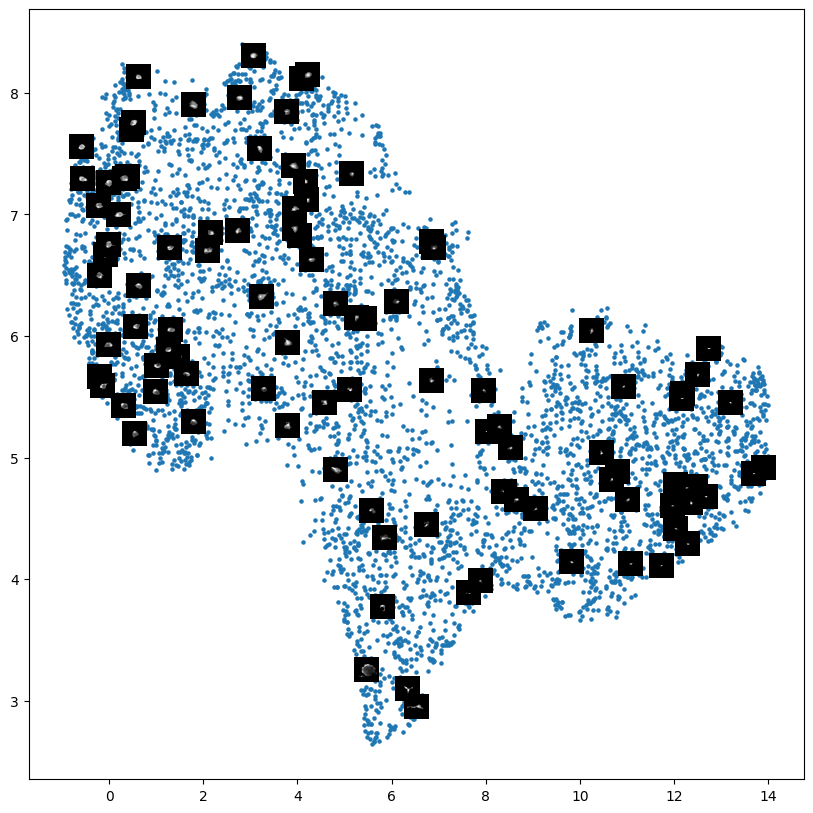

In [23]:
if params['run_umap']:
    umap_params = dict(
        n_neighbors=30,
        n_components=2,
        metric='euclidean',
        metric_kwds=None,
        output_metric='euclidean',
        output_metric_kwds=None,
        n_epochs=None,
        learning_rate=1.0,
        init='spectral',
        min_dist=0.1,
        spread=1.0,
        low_memory=True,
        n_jobs=-1,
        set_op_mix_ratio=1.0,
        local_connectivity=1.0,
        repulsion_strength=1.0,
        negative_sample_rate=5,
        transform_queue_size=4.0,
        a=None,
        b=None,
        random_state=None,
        angular_rp_forest=False,
        target_n_neighbors=-1,
        target_metric='categorical',
        target_metric_kwds=None,
        target_weight=0.5,
        transform_seed=42,
        transform_mode='embedding',
        force_approximation_algorithm=False,
        verbose=False,
        tqdm_kwds=None,
        unique=False,
        densmap=False,
        dens_lambda=2.0,
        dens_frac=0.3,
        dens_var_shift=0.1,
        output_dens=False,
        disconnection_distance=None,
        precomputed_knn=(None, None, None),
    )

    umap_model = umap.UMAP(**umap_params)
    print('Fitting UMAP...')
    umap_model.fit(roinet.latents)

    if params['paths']['filepath_umapModel']:
        raise NotImplementedError('Saving UMAP to file not yet implemented.') # TODO: JZ, Implement saving UMAP to file
        # print(f'Saving UMAP to {params["paths"]["filepath_umapModel"]}...')
        # joblib.dump(umap, params['paths']['filepath_umapModel'])
    else:
        print('Unspecified filepath_umapModel in params... not saving UMAP to file.')
elif params['paths']['filepath_umapModel']:
    raise NotImplementedError('Loading UMAP from file not yet implemented.') # TODO: JZ, Implement loading UMAP from file
    # print(f'Loading UMAP from {params["paths"]["filepath_umapModel"]}...')
    # umap = joblib.load(params['paths']['filepath_umapModel'])
else:
    raise ValueError(f'run_umap must be True or filepath_umapModel must be specified in params.')

print('Generating Embeddings...')
embeddings = umap_model.transform(roinet.latents)
labelingRun_interim['embeddings'] = embeddings
print('Embeddings Generated...')
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(embeddings[:,0], embeddings[:,1], s=5, cmap='gist_rainbow')

inx_lst = np.arange(np.concatenate(data.ROI_images).shape[0])
inx_lst = np.random.choice(inx_lst, 100, replace=False)
img_lst = np.concatenate(data.ROI_images)[inx_lst]
x = embeddings[inx_lst, 0]
y = embeddings[inx_lst, 1]

for x0, y0, ROI_single in zip(x, y, img_lst):
    offsetImage = matplotlib.offsetbox.OffsetImage(ROI_single, cmap='gray', zoom=0.5) # initialize offset image to contain ROI visualization
    ab = matplotlib.offsetbox.AnnotationBbox(offsetImage, (x0, y0), frameon=False)
    ax.add_artist(ab)

# TODO: JZ, Add Circling Code for Labeling
if testing:
    num_zeroLabels = np.concatenate(data.ROI_images).shape[0]//2
    num_onesLabels = np.concatenate(data.ROI_images).shape[0] - np.concatenate(data.ROI_images).shape[0]//2
    arr_labels = np.concatenate([np.zeros(num_zeroLabels), np.ones(num_onesLabels)])
else:
    raise NotImplementedError('Saving UMAP to file not yet implemented.') # TODO: JZ, Implement saving UMAP to file

# Save Outputs

In [26]:
with open(str((Path(directory_save) / 'feature_label_combo.npy').resolve()), 'wb') as f:
    np.save(
        file=f,
        arr={
            'rois': data.ROI_images,
            'latents': roinet.latents,
            'embeddings': embeddings,
            'labels': arr_labels,
        },
        allow_pickle=True,
    )
with open(str((Path(directory_save) / 'pkl_labelingRunInterim.npy').resolve()), 'wb') as f:
    np.save(
        file=f,
        arr=labelingRun_interim,
        allow_pickle=True
    )

print(f'Saving files completed.')

Saving files completed.
